# Portfolio CAPM Analysis

This notebook analyzes a stock portfolio against the Capital Asset Pricing Model (CAPM) using the S&P 500 as the market portfolio.

In [100]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

## 1. Configuration

In [101]:
# Portfolio configuration
# Example portfolio - modify these tickers and weights as needed
PORTFOLIO = {
    'AAPL': 0.25,
    'MSFT': 0.10,
    'GOOGL': 0.20,
    'AMZN': 0.15,
    'NVDA': 0.15,
    'PG': 0.15
}

# Market portfolio (S&P 500)
MARKET_TICKER = '^GSPC'

# Risk-free rate proxy (3-month Treasury Bill)
RISK_FREE_TICKER = '^IRX'

# Analysis period
START_DATE = '2000-01-01'
END_DATE = datetime.now().strftime('%Y-%m-%d')

print(f"Portfolio: {list(PORTFOLIO.keys())}")
print(f"Weights: {list(PORTFOLIO.values())}")
print(f"Analysis period: {START_DATE} to {END_DATE}")

Portfolio: ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA', 'PG']
Weights: [0.25, 0.1, 0.2, 0.15, 0.15, 0.15]
Analysis period: 2000-01-01 to 2025-08-25


## 2. Data Collection

In [102]:
def fetch_stock_data(tickers, start_date, end_date):
    """
    Fetch historical stock data for given tickers
    """
    data = {}
    for ticker in tickers:
        print(f"Fetching data for {ticker}...")
        stock = yf.Ticker(ticker)
        hist = stock.history(start=start_date, end=end_date)
        data[ticker] = hist['Close']
    return pd.DataFrame(data)

# Fetch all data
all_tickers = list(PORTFOLIO.keys()) + [MARKET_TICKER]
price_data = fetch_stock_data(all_tickers, START_DATE, END_DATE)

# Fetch risk-free rate data
rf_data = yf.Ticker(RISK_FREE_TICKER).history(start=START_DATE, end=END_DATE)['Close']

print(f"\nData shape: {price_data.shape}")
print(f"Date range: {price_data.index[0].date()} to {price_data.index[-1].date()}")
price_data.head()

Fetching data for AAPL...
Fetching data for MSFT...
Fetching data for GOOGL...
Fetching data for AMZN...
Fetching data for NVDA...
Fetching data for PG...
Fetching data for ^GSPC...

Data shape: (6449, 7)
Date range: 2000-01-03 to 2025-08-22


,AAPL,MSFT,GOOGL,AMZN,NVDA,PG,^GSPC
Date,,,,,,,
2000-01-03 00:00:00-05:00,0.840094,35.668087,NaN,4.468750,0.089425,27.213194,1455.219971
2000-01-04 00:00:00-05:00,0.769266,34.463203,NaN,4.096875,0.087038,26.689575,1399.420044
2000-01-05 00:00:00-05:00,0.780523,34.826588,NaN,3.487500,0.084172,26.181784,1402.109985
2000-01-06 00:00:00-05:00,0.712978,33.659969,NaN,3.278125,0.078680,27.387735,1403.449951
2000-01-07 00:00:00-05:00,0.746751,34.099815,NaN,3.478125,0.079994,29.577478,1441.469971


## 3. Returns Calculation

In [103]:
def calculate_returns(prices, period='daily'):
    """
    Calculate returns for different periods
    
    Parameters:
    - prices: DataFrame of price data
    - period: 'daily', 'weekly', or 'monthly'
    """
    if period == 'daily':
        returns = prices.pct_change().dropna()
    elif period == 'weekly':
        weekly_prices = prices.resample('W').last()
        returns = weekly_prices.pct_change().dropna()
    elif period == 'monthly':
        monthly_prices = prices.resample('M').last()
        returns = monthly_prices.pct_change().dropna()
    else:
        raise ValueError("Period must be 'daily', 'weekly', or 'monthly'")
    
    return returns

# Calculate returns for different periods
daily_returns = calculate_returns(price_data, 'daily')
weekly_returns = calculate_returns(price_data, 'weekly')
monthly_returns = calculate_returns(price_data, 'monthly')

print("Returns calculated:")
print(f"Daily: {daily_returns.shape[0]} observations")
print(f"Weekly: {weekly_returns.shape[0]} observations")
print(f"Monthly: {monthly_returns.shape[0]} observations")

Returns calculated:
Daily: 5286 observations
Weekly: 1096 observations
Monthly: 252 observations


## 4. Portfolio Returns Calculation

In [104]:
def calculate_portfolio_returns(returns, weights):
    """
    Calculate portfolio returns based on weights
    """
    portfolio_tickers = list(weights.keys())
    
    # Check if all portfolio tickers exist in returns
    missing_tickers = [t for t in portfolio_tickers if t not in returns.columns]
    if missing_tickers:
        print(f"Warning: Missing tickers in returns data: {missing_tickers}")
        portfolio_tickers = [t for t in portfolio_tickers if t in returns.columns]
    
    if not portfolio_tickers:
        print("Error: No valid tickers found in returns data")
        return pd.Series(dtype=float)
    
    # Calculate weighted returns
    weighted_returns = pd.Series(index=returns.index, dtype=float)
    weighted_returns[:] = 0.0  # Initialize with zeros
    
    for ticker in portfolio_tickers:
        if ticker in weights:
            weighted_returns += returns[ticker] * weights[ticker]
    
    return weighted_returns

# Calculate portfolio returns for different periods
portfolio_daily = calculate_portfolio_returns(daily_returns, PORTFOLIO)
portfolio_weekly = calculate_portfolio_returns(weekly_returns, PORTFOLIO)
portfolio_monthly = calculate_portfolio_returns(monthly_returns, PORTFOLIO)

print("Portfolio returns calculated for all periods")
print(f"Daily portfolio returns shape: {portfolio_daily.shape}, non-null: {portfolio_daily.notna().sum()}")
print(f"Weekly portfolio returns shape: {portfolio_weekly.shape}, non-null: {portfolio_weekly.notna().sum()}")
print(f"Monthly portfolio returns shape: {portfolio_monthly.shape}, non-null: {portfolio_monthly.notna().sum()}")

# Quick check of first few values
print("\nFirst 5 daily portfolio returns:")
print(portfolio_daily.head())
print(f"\nMean daily portfolio return: {portfolio_daily.mean():.4%}")
print(f"Mean daily market return: {daily_returns[MARKET_TICKER].mean():.4%}")

Portfolio returns calculated for all periods
Daily portfolio returns shape: (5286,), non-null: 5286
Weekly portfolio returns shape: (1096,), non-null: 1096
Monthly portfolio returns shape: (252,), non-null: 252

First 5 daily portfolio returns:
Date
2004-08-20 00:00:00-04:00    0.030226
2004-08-23 00:00:00-04:00    0.007506
2004-08-24 00:00:00-04:00   -0.007843
2004-08-25 00:00:00-04:00    0.024077
2004-08-26 00:00:00-04:00    0.016414
dtype: float64

Mean daily portfolio return: 0.1150%
Mean daily market return: 0.0409%


## 5. CAPM Analysis

In [105]:
def calculate_capm_metrics(portfolio_returns, market_returns, risk_free_rate=0.02, period='daily'):
    """
    Calculate CAPM metrics including beta, alpha, and expected returns
    """
    # Annualization factors
    annualization = {'daily': 252, 'weekly': 52, 'monthly': 12}
    periods_per_year = annualization[period]
    
    # Adjust risk-free rate to match period
    rf_period = risk_free_rate / periods_per_year
    
    # Ensure both series are aligned and have no NaN values
    aligned_data = pd.DataFrame({
        'portfolio': portfolio_returns,
        'market': market_returns
    }).dropna()
    
    if aligned_data.empty:
        print(f"Warning: No valid data for {period} analysis")
        return {}, None
    
    portfolio_returns_clean = aligned_data['portfolio']
    market_returns_clean = aligned_data['market']
    
    # Calculate excess returns
    portfolio_excess = portfolio_returns_clean - rf_period
    market_excess = market_returns_clean - rf_period
    
    # Calculate beta using regression
    X = sm.add_constant(market_excess)
    model = sm.OLS(portfolio_excess, X)
    results = model.fit()
    
    alpha = results.params[0]
    beta = results.params[1]
    
    # Calculate additional metrics
    portfolio_return_annual = portfolio_returns_clean.mean() * periods_per_year
    market_return_annual = market_returns_clean.mean() * periods_per_year
    portfolio_vol_annual = portfolio_returns_clean.std() * np.sqrt(periods_per_year)
    market_vol_annual = market_returns_clean.std() * np.sqrt(periods_per_year)
    
    # CAPM expected return
    capm_expected_return = risk_free_rate + beta * (market_return_annual - risk_free_rate)
    
    # Sharpe ratios
    portfolio_sharpe = (portfolio_return_annual - risk_free_rate) / portfolio_vol_annual if portfolio_vol_annual != 0 else np.nan
    market_sharpe = (market_return_annual - risk_free_rate) / market_vol_annual if market_vol_annual != 0 else np.nan
    
    # Treynor ratio
    treynor_ratio = (portfolio_return_annual - risk_free_rate) / beta if beta != 0 else np.nan
    
    # Information ratio (using alpha)
    tracking_error = (portfolio_returns_clean - market_returns_clean).std() * np.sqrt(periods_per_year)
    information_ratio = (alpha * periods_per_year) / tracking_error if tracking_error != 0 else np.nan
    
    metrics = {
        'beta': beta,
        'alpha_annual': alpha * periods_per_year,
        'r_squared': results.rsquared,
        'portfolio_return': portfolio_return_annual,
        'market_return': market_return_annual,
        'capm_expected_return': capm_expected_return,
        'portfolio_volatility': portfolio_vol_annual,
        'market_volatility': market_vol_annual,
        'portfolio_sharpe': portfolio_sharpe,
        'market_sharpe': market_sharpe,
        'treynor_ratio': treynor_ratio,
        'information_ratio': information_ratio,
        'tracking_error': tracking_error
    }
    
    return metrics, results

# Get current risk-free rate (approximate)
current_rf_rate = rf_data.iloc[-1] / 100 if not rf_data.empty else 0.045  # Default to 4.5% if data unavailable

# Perform CAPM analysis for different periods
periods = ['daily', 'weekly', 'monthly']
returns_data = {
    'daily': (portfolio_daily, daily_returns[MARKET_TICKER]),
    'weekly': (portfolio_weekly, weekly_returns[MARKET_TICKER]),
    'monthly': (portfolio_monthly, monthly_returns[MARKET_TICKER])
}

capm_results = {}
regression_results = {}

for period in periods:
    portfolio_ret, market_ret = returns_data[period]
    metrics, reg_results = calculate_capm_metrics(portfolio_ret, market_ret, current_rf_rate, period)
    if metrics:  # Only add if we got valid results
        capm_results[period] = metrics
        regression_results[period] = reg_results

# Display results
results_df = pd.DataFrame(capm_results).T
results_df

,beta,alpha_annual,r_squared,portfolio_return,market_return,capm_expected_return,portfolio_volatility,market_volatility,portfolio_sharpe,market_sharpe,treynor_ratio,information_ratio,tracking_error
daily,1.068500,0.182402,0.707752,0.289857,0.103187,0.107455,0.243006,0.191330,1.024572,0.325652,0.233015,1.381613,0.132021
weekly,1.051065,0.180976,0.651644,0.283615,0.099639,0.102639,0.227765,0.174929,1.065726,0.335900,0.230942,1.343275,0.134727
monthly,1.130156,0.181417,0.584150,0.284097,0.095563,0.102681,0.219331,0.148328,1.108906,0.368665,0.215207,1.270867,0.142750


## 6. Risk-Return Analysis

In [106]:
def analyze_risk_return(capm_results, period='monthly'):
    """
    Analyze if portfolio takes on too much risk relative to returns
    """
    metrics = capm_results[period]
    
    print(f"\n{'='*60}")
    print(f"RISK-RETURN ANALYSIS ({period.upper()} DATA)")
    print(f"{'='*60}\n")
    
    print("PORTFOLIO METRICS:")
    print(f"  Beta: {metrics['beta']:.3f}")
    print(f"  Actual Return (annual): {metrics['portfolio_return']*100:.2f}%")
    print(f"  CAPM Expected Return: {metrics['capm_expected_return']*100:.2f}%")
    print(f"  Alpha (annual): {metrics['alpha_annual']*100:.2f}%")
    print(f"  Volatility (annual): {metrics['portfolio_volatility']*100:.2f}%")
    print(f"  R-squared: {metrics['r_squared']:.3f}")
    
    print(f"\nMARKET METRICS:")
    print(f"  Market Return (annual): {metrics['market_return']*100:.2f}%")
    print(f"  Market Volatility (annual): {metrics['market_volatility']*100:.2f}%")
    
    print(f"\nRISK-ADJUSTED PERFORMANCE:")
    print(f"  Sharpe Ratio (Portfolio): {metrics['portfolio_sharpe']:.3f}")
    print(f"  Sharpe Ratio (Market): {metrics['market_sharpe']:.3f}")
    print(f"  Treynor Ratio: {metrics['treynor_ratio']:.3f}")
    print(f"  Information Ratio: {metrics['information_ratio']:.3f}")
    print(f"  Tracking Error: {metrics['tracking_error']*100:.2f}%")
    
    print(f"\n{'='*60}")
    print("INTERPRETATION:")
    print(f"{'='*60}\n")
    
    # Beta interpretation
    if metrics['beta'] > 1.2:
        print(f"⚠️  HIGH BETA ({metrics['beta']:.2f}): Portfolio is significantly more volatile than the market.")
        print("   This indicates aggressive risk-taking that may not be suitable for risk-averse investors.")
    elif metrics['beta'] > 1:
        print(f"📊 MODERATE-HIGH BETA ({metrics['beta']:.2f}): Portfolio is somewhat more volatile than the market.")
    elif metrics['beta'] > 0.8:
        print(f"✅ MODERATE BETA ({metrics['beta']:.2f}): Portfolio has similar volatility to the market.")
    else:
        print(f"🛡️  LOW BETA ({metrics['beta']:.2f}): Portfolio is less volatile than the market (defensive).")
    
    # Alpha interpretation
    if metrics['alpha_annual'] > 0.02:
        print(f"\n✅ POSITIVE ALPHA ({metrics['alpha_annual']*100:.2f}%): Portfolio is outperforming CAPM expectations!")
        print("   The portfolio is generating excess returns beyond what its risk level would predict.")
    elif metrics['alpha_annual'] < -0.02:
        print(f"\n⚠️  NEGATIVE ALPHA ({metrics['alpha_annual']*100:.2f}%): Portfolio is underperforming CAPM expectations.")
        print("   Consider whether the additional risk is justified or if rebalancing is needed.")
    else:
        print(f"\n📊 NEUTRAL ALPHA ({metrics['alpha_annual']*100:.2f}%): Portfolio performs as expected by CAPM.")
    
    # Risk-adjusted performance
    if metrics['portfolio_sharpe'] > metrics['market_sharpe']:
        print(f"\n✅ SUPERIOR RISK-ADJUSTED RETURNS: Portfolio Sharpe ({metrics['portfolio_sharpe']:.3f}) > Market Sharpe ({metrics['market_sharpe']:.3f})")
        print("   The portfolio is providing better returns per unit of risk than the market.")
    else:
        print(f"\n⚠️  INFERIOR RISK-ADJUSTED RETURNS: Portfolio Sharpe ({metrics['portfolio_sharpe']:.3f}) < Market Sharpe ({metrics['market_sharpe']:.3f})")
        print("   Consider reducing risk or improving returns through rebalancing.")
    
    # Overall assessment
    risk_score = 0
    if metrics['beta'] > 1.2:
        risk_score += 2
    elif metrics['beta'] > 1:
        risk_score += 1
    
    if metrics['alpha_annual'] < -0.02:
        risk_score += 2
    elif metrics['alpha_annual'] < 0:
        risk_score += 1
    
    if metrics['portfolio_sharpe'] < metrics['market_sharpe']:
        risk_score += 1
    
    print(f"\n{'='*60}")
    print("OVERALL ASSESSMENT:")
    print(f"{'='*60}")
    
    if risk_score >= 4:
        print("\n🔴 HIGH RISK CONCERN: Portfolio appears to be taking excessive risk relative to returns.")
        print("   RECOMMENDATION: Consider rebalancing to reduce beta or improve stock selection.")
    elif risk_score >= 2:
        print("\n🟡 MODERATE RISK CONCERN: Portfolio shows some risk-return imbalance.")
        print("   RECOMMENDATION: Monitor performance and consider minor adjustments.")
    else:
        print("\n🟢 ACCEPTABLE RISK PROFILE: Portfolio risk appears justified by returns.")
        print("   RECOMMENDATION: Continue monitoring but no immediate action required.")

# Analyze for each period
for period in ['daily', 'weekly', 'monthly']:
    analyze_risk_return(capm_results, period)


RISK-RETURN ANALYSIS (DAILY DATA)

PORTFOLIO METRICS:
  Beta: 1.068
  Actual Return (annual): 28.99%
  CAPM Expected Return: 10.75%
  Alpha (annual): 18.24%
  Volatility (annual): 24.30%
  R-squared: 0.708

MARKET METRICS:
  Market Return (annual): 10.32%
  Market Volatility (annual): 19.13%

RISK-ADJUSTED PERFORMANCE:
  Sharpe Ratio (Portfolio): 1.025
  Sharpe Ratio (Market): 0.326
  Treynor Ratio: 0.233
  Information Ratio: 1.382
  Tracking Error: 13.20%

INTERPRETATION:

📊 MODERATE-HIGH BETA (1.07): Portfolio is somewhat more volatile than the market.

✅ POSITIVE ALPHA (18.24%): Portfolio is outperforming CAPM expectations!
   The portfolio is generating excess returns beyond what its risk level would predict.

✅ SUPERIOR RISK-ADJUSTED RETURNS: Portfolio Sharpe (1.025) > Market Sharpe (0.326)
   The portfolio is providing better returns per unit of risk than the market.

OVERALL ASSESSMENT:

🟢 ACCEPTABLE RISK PROFILE: Portfolio risk appears justified by returns.
   RECOMMENDATION: 

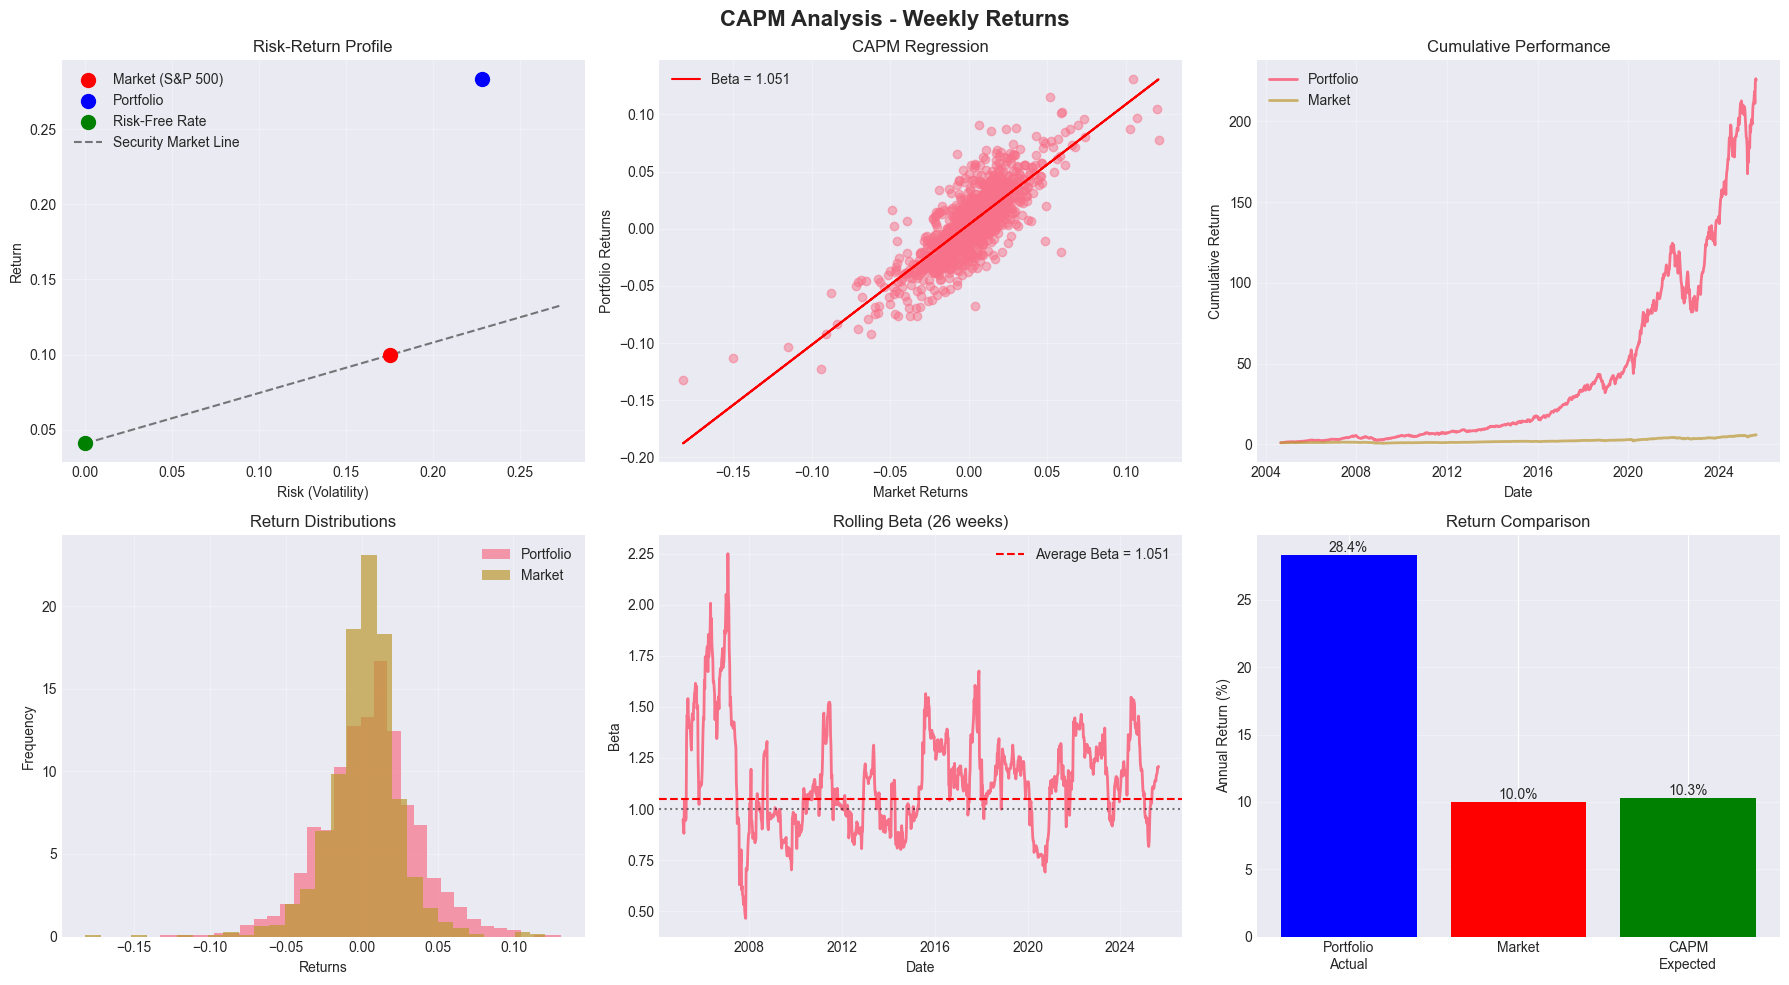

In [107]:
# Set up visualization period - USING WEEKLY RETURNS
viz_period = 'weekly'  # Changed from 'monthly' to 'weekly'
portfolio_ret, market_ret = returns_data[viz_period]
metrics = capm_results[viz_period]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'CAPM Analysis - {viz_period.capitalize()} Returns', fontsize=16, fontweight='bold')

# 1. Security Market Line
ax = axes[0, 0]
ax.scatter(metrics['market_volatility'], metrics['market_return'], 
           color='red', s=100, label='Market (S&P 500)', zorder=5)
ax.scatter(metrics['portfolio_volatility'], metrics['portfolio_return'], 
           color='blue', s=100, label='Portfolio', zorder=5)
ax.scatter(0, current_rf_rate, color='green', s=100, label='Risk-Free Rate', zorder=5)

# Draw Security Market Line
x_range = np.linspace(0, max(metrics['portfolio_volatility'], metrics['market_volatility']) * 1.2, 100)
sml = current_rf_rate + (metrics['market_return'] - current_rf_rate) / metrics['market_volatility'] * x_range
ax.plot(x_range, sml, 'k--', alpha=0.5, label='Security Market Line')

ax.set_xlabel('Risk (Volatility)')
ax.set_ylabel('Return')
ax.set_title('Risk-Return Profile')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Regression Plot
ax = axes[0, 1]
ax.scatter(market_ret, portfolio_ret, alpha=0.5)
z = np.polyfit(market_ret, portfolio_ret, 1)
p = np.poly1d(z)
ax.plot(market_ret, p(market_ret), "r-", label=f'Beta = {metrics["beta"]:.3f}')
ax.set_xlabel('Market Returns')
ax.set_ylabel('Portfolio Returns')
ax.set_title('CAPM Regression')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Cumulative Returns
ax = axes[0, 2]
cum_portfolio = (1 + portfolio_ret).cumprod()
cum_market = (1 + market_ret).cumprod()
ax.plot(cum_portfolio.index, cum_portfolio, label='Portfolio', linewidth=2)
ax.plot(cum_market.index, cum_market, label='Market', linewidth=2, alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.set_title('Cumulative Performance')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Return Distribution
ax = axes[1, 0]
ax.hist(portfolio_ret, bins=30, alpha=0.7, label='Portfolio', density=True)
ax.hist(market_ret, bins=30, alpha=0.7, label='Market', density=True)
ax.set_xlabel('Returns')
ax.set_ylabel('Frequency')
ax.set_title('Return Distributions')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Rolling Beta
ax = axes[1, 1]
window = 26  # 26 weeks (approximately 6 months)
rolling_cov = portfolio_ret.rolling(window=window).cov(market_ret)
rolling_var = market_ret.rolling(window=window).var()
rolling_beta = rolling_cov / rolling_var
ax.plot(rolling_beta.index, rolling_beta, linewidth=2)
ax.axhline(y=metrics['beta'], color='r', linestyle='--', label=f'Average Beta = {metrics["beta"]:.3f}')
ax.axhline(y=1, color='k', linestyle=':', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Beta')
ax.set_title(f'Rolling Beta ({window} weeks)')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Performance Metrics Bar Chart
ax = axes[1, 2]
metrics_to_plot = ['portfolio_return', 'market_return', 'capm_expected_return']
values = [metrics[m] * 100 for m in metrics_to_plot]
colors = ['blue', 'red', 'green']
bars = ax.bar(['Portfolio\nActual', 'Market', 'CAPM\nExpected'], values, color=colors)
ax.set_ylabel('Annual Return (%)')
ax.set_title('Return Comparison')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

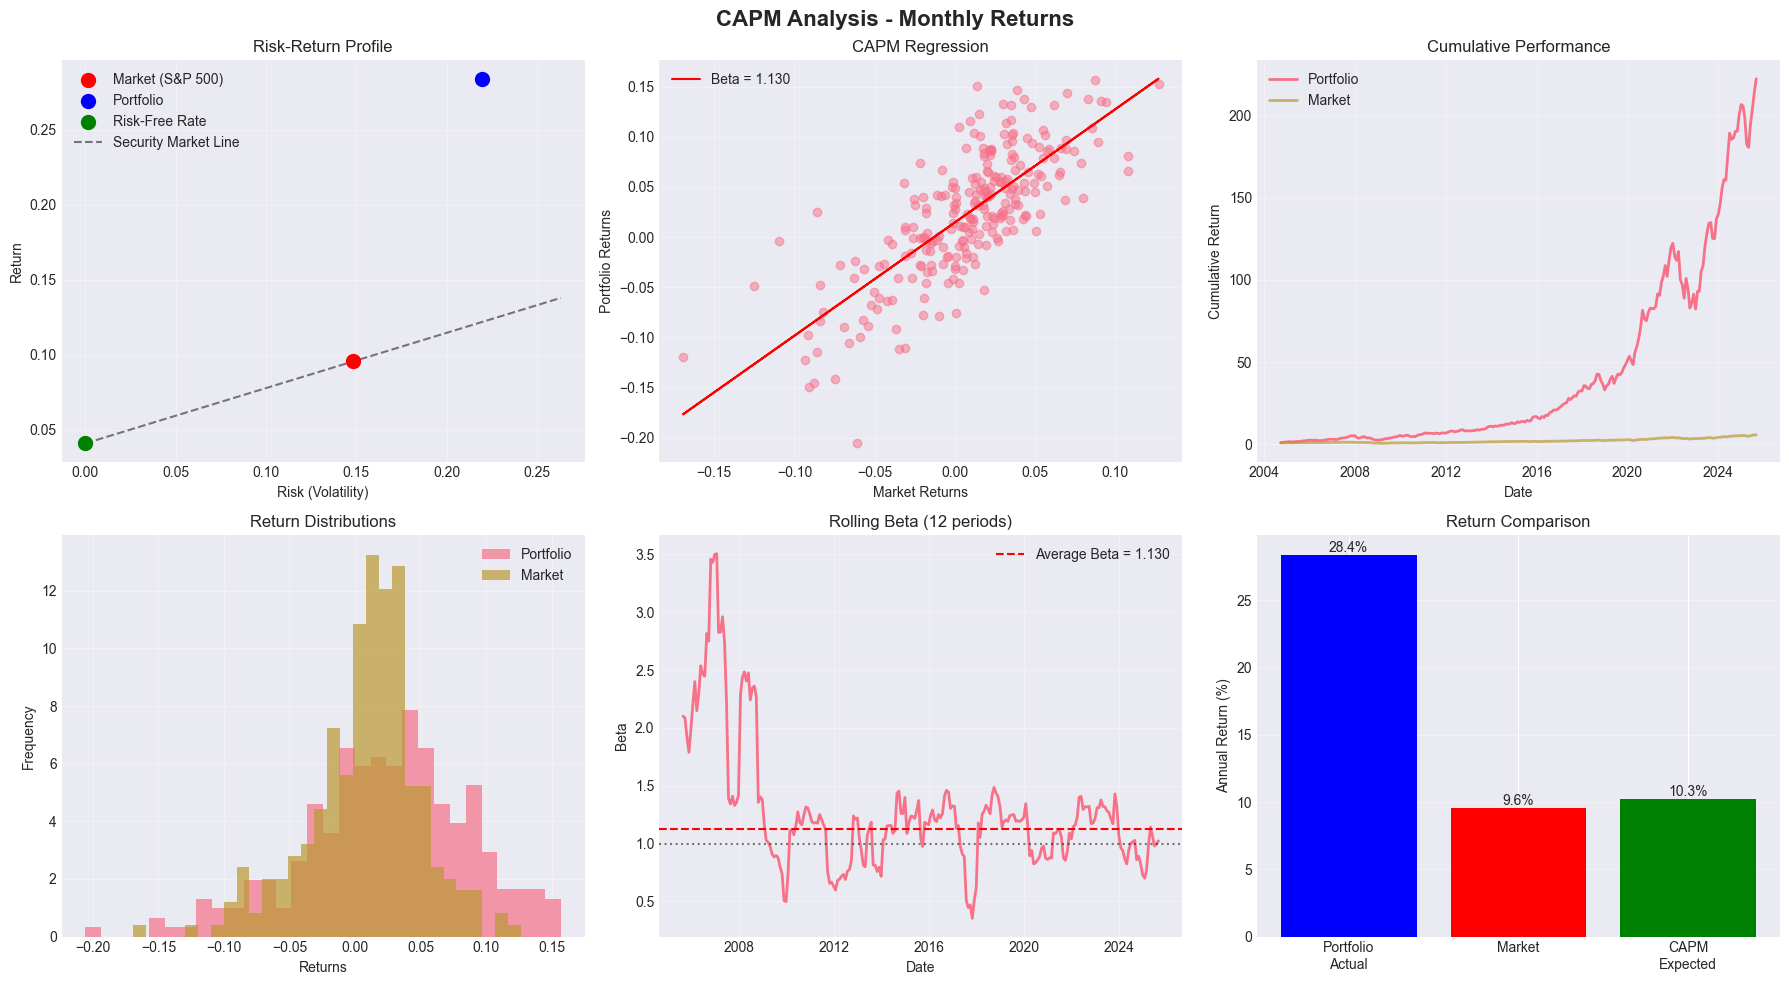

In [108]:
# Set up visualization period
viz_period = 'monthly'  # Change to 'daily' or 'weekly' as needed
portfolio_ret, market_ret = returns_data[viz_period]
metrics = capm_results[viz_period]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle(f'CAPM Analysis - {viz_period.capitalize()} Returns', fontsize=16, fontweight='bold')

# 1. Security Market Line
ax = axes[0, 0]
ax.scatter(metrics['market_volatility'], metrics['market_return'], 
           color='red', s=100, label='Market (S&P 500)', zorder=5)
ax.scatter(metrics['portfolio_volatility'], metrics['portfolio_return'], 
           color='blue', s=100, label='Portfolio', zorder=5)
ax.scatter(0, current_rf_rate, color='green', s=100, label='Risk-Free Rate', zorder=5)

# Draw Security Market Line
x_range = np.linspace(0, max(metrics['portfolio_volatility'], metrics['market_volatility']) * 1.2, 100)
sml = current_rf_rate + (metrics['market_return'] - current_rf_rate) / metrics['market_volatility'] * x_range
ax.plot(x_range, sml, 'k--', alpha=0.5, label='Security Market Line')

ax.set_xlabel('Risk (Volatility)')
ax.set_ylabel('Return')
ax.set_title('Risk-Return Profile')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Regression Plot
ax = axes[0, 1]
ax.scatter(market_ret, portfolio_ret, alpha=0.5)
z = np.polyfit(market_ret, portfolio_ret, 1)
p = np.poly1d(z)
ax.plot(market_ret, p(market_ret), "r-", label=f'Beta = {metrics["beta"]:.3f}')
ax.set_xlabel('Market Returns')
ax.set_ylabel('Portfolio Returns')
ax.set_title('CAPM Regression')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Cumulative Returns
ax = axes[0, 2]
cum_portfolio = (1 + portfolio_ret).cumprod()
cum_market = (1 + market_ret).cumprod()
ax.plot(cum_portfolio.index, cum_portfolio, label='Portfolio', linewidth=2)
ax.plot(cum_market.index, cum_market, label='Market', linewidth=2, alpha=0.7)
ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.set_title('Cumulative Performance')
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Return Distribution
ax = axes[1, 0]
ax.hist(portfolio_ret, bins=30, alpha=0.7, label='Portfolio', density=True)
ax.hist(market_ret, bins=30, alpha=0.7, label='Market', density=True)
ax.set_xlabel('Returns')
ax.set_ylabel('Frequency')
ax.set_title('Return Distributions')
ax.legend()
ax.grid(True, alpha=0.3)

# 5. Rolling Beta
ax = axes[1, 1]
window = 60 if viz_period == 'daily' else 12  # 60 days or 12 weeks/months
rolling_cov = portfolio_ret.rolling(window=window).cov(market_ret)
rolling_var = market_ret.rolling(window=window).var()
rolling_beta = rolling_cov / rolling_var
ax.plot(rolling_beta.index, rolling_beta, linewidth=2)
ax.axhline(y=metrics['beta'], color='r', linestyle='--', label=f'Average Beta = {metrics["beta"]:.3f}')
ax.axhline(y=1, color='k', linestyle=':', alpha=0.5)
ax.set_xlabel('Date')
ax.set_ylabel('Beta')
ax.set_title(f'Rolling Beta ({window} periods)')
ax.legend()
ax.grid(True, alpha=0.3)

# 6. Performance Metrics Bar Chart
ax = axes[1, 2]
metrics_to_plot = ['portfolio_return', 'market_return', 'capm_expected_return']
values = [metrics[m] * 100 for m in metrics_to_plot]
colors = ['blue', 'red', 'green']
bars = ax.bar(['Portfolio\nActual', 'Market', 'CAPM\nExpected'], values, color=colors)
ax.set_ylabel('Annual Return (%)')
ax.set_title('Return Comparison')
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.1f}%', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [109]:
def analyze_individual_stocks(returns, market_returns, portfolio_weights, risk_free_rate=0.02, period='weekly'):
    """
    Analyze individual stocks in the portfolio using WEEKLY returns
    """
    annualization = {'daily': 252, 'weekly': 52, 'monthly': 12}
    periods_per_year = annualization[period]
    rf_period = risk_free_rate / periods_per_year
    
    stock_metrics = {}
    
    for ticker in portfolio_weights.keys():
        stock_returns = returns[ticker]
        
        # Calculate beta
        stock_excess = stock_returns - rf_period
        market_excess = market_returns - rf_period
        
        X = sm.add_constant(market_excess)
        model = sm.OLS(stock_excess, X)
        results = model.fit()
        
        beta = results.params[1]
        alpha = results.params[0] * periods_per_year
        
        # Calculate returns and volatility
        annual_return = stock_returns.mean() * periods_per_year
        annual_vol = stock_returns.std() * np.sqrt(periods_per_year)
        
        # CAPM expected return
        market_return_annual = market_returns.mean() * periods_per_year
        capm_expected = risk_free_rate + beta * (market_return_annual - risk_free_rate)
        
        # Sharpe ratio
        sharpe = (annual_return - risk_free_rate) / annual_vol if annual_vol != 0 else np.nan
        
        stock_metrics[ticker] = {
            'Weight': portfolio_weights[ticker],
            'Beta': beta,
            'Alpha (%)': alpha * 100,
            'Return (%)': annual_return * 100,
            'CAPM Expected (%)': capm_expected * 100,
            'Volatility (%)': annual_vol * 100,
            'Sharpe Ratio': sharpe,
            'Contribution to Portfolio Return (%)': portfolio_weights[ticker] * annual_return * 100
        }
    
    return pd.DataFrame(stock_metrics).T

# Analyze individual stocks using WEEKLY returns
stock_analysis = analyze_individual_stocks(
    weekly_returns,  # Changed from monthly_returns to weekly_returns
    weekly_returns[MARKET_TICKER], 
    PORTFOLIO, 
    current_rf_rate, 
    'weekly'  # Changed from 'monthly' to 'weekly'
)

print("\nINDIVIDUAL STOCK ANALYSIS (Weekly Data)")
print("="*80)
stock_analysis.round(3)


INDIVIDUAL STOCK ANALYSIS (Weekly Data)


,Weight,Beta,Alpha (%),Return (%),CAPM Expected (%),Volatility (%),Sharpe Ratio,Contribution to Portfolio Return (%)
AAPL,0.25,1.075,24.259,34.665,10.406,32.102,0.952,8.666
MSFT,0.10,0.907,9.713,19.130,9.417,24.243,0.620,1.913
GOOGL,0.20,1.038,14.938,25.128,10.189,30.231,0.696,5.026
AMZN,0.15,1.073,18.432,28.825,10.394,35.655,0.694,4.324
NVDA,0.15,1.650,33.238,47.023,13.785,47.349,0.907,7.053
PG,0.15,0.502,2.156,9.196,7.040,16.741,0.305,1.379


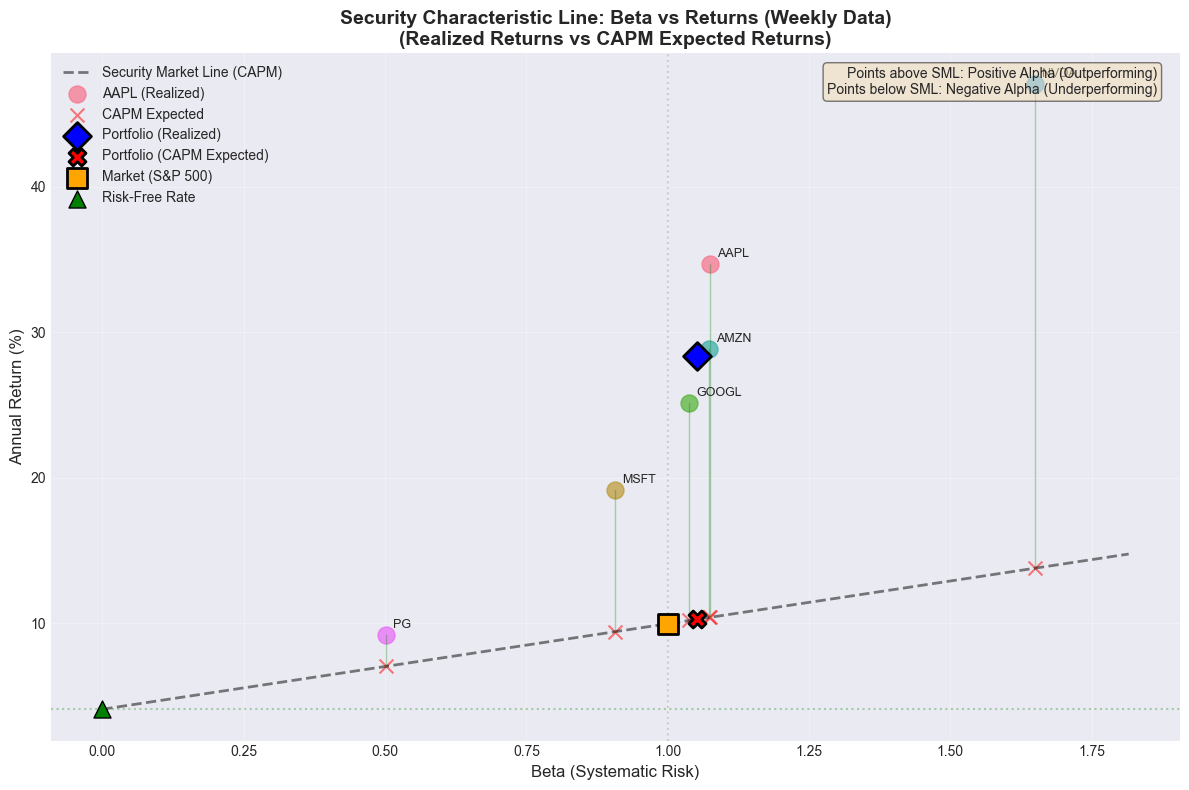


SUMMARY: Beta vs Returns Analysis (Weekly Data)
Stock          Beta     Realized   CAPM Expected      Alpha
------------------------------------------------------------
AAPL          1.075       34.67%          10.41%     24.26%
MSFT          0.907       19.13%           9.42%      9.71%
GOOGL         1.038       25.13%          10.19%     14.94%
AMZN          1.073       28.83%          10.39%     18.43%
NVDA          1.650       47.02%          13.78%     33.24%
PG            0.502        9.20%           7.04%      2.16%
------------------------------------------------------------
PORTFOLIO     1.051       28.36%          10.26%     18.10%
MARKET        1.000        9.96%           9.96%      0.00%


In [110]:
# Security Characteristic Line - Beta vs Returns Chart
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Get the analysis period (using WEEKLY for visualization)
analysis_period = 'weekly'  # Changed from 'monthly' to 'weekly'
market_return = capm_results[analysis_period]['market_return']
rf_rate = current_rf_rate

# Prepare data for individual stocks
stock_betas = []
stock_realized_returns = []
stock_expected_returns = []
stock_names = []

for ticker in PORTFOLIO.keys():
    # Get stock data from the stock_analysis DataFrame
    if ticker in stock_analysis.index:
        beta = stock_analysis.loc[ticker, 'Beta']
        realized_return = stock_analysis.loc[ticker, 'Return (%)'] / 100  # Convert from percentage
        expected_return = rf_rate + beta * (market_return - rf_rate)
        
        stock_betas.append(beta)
        stock_realized_returns.append(realized_return)
        stock_expected_returns.append(expected_return)
        stock_names.append(ticker)

# Add portfolio point
portfolio_beta = capm_results[analysis_period]['beta']
portfolio_realized = capm_results[analysis_period]['portfolio_return']
portfolio_expected = capm_results[analysis_period]['capm_expected_return']

# Create beta range for Security Market Line
beta_range = np.linspace(0, max(stock_betas + [portfolio_beta]) * 1.1, 100)
sml_returns = rf_rate + beta_range * (market_return - rf_rate)

# Plot Security Market Line
ax.plot(beta_range, sml_returns * 100, 'k--', alpha=0.5, linewidth=2, label='Security Market Line (CAPM)')

# Plot individual stocks
for i, ticker in enumerate(stock_names):
    # Realized returns
    ax.scatter(stock_betas[i], stock_realized_returns[i] * 100, s=150, alpha=0.7, 
               marker='o', label=f'{ticker} (Realized)' if i == 0 else '')
    # Expected returns on SML
    ax.scatter(stock_betas[i], stock_expected_returns[i] * 100, s=100, alpha=0.5, 
               marker='x', color='red', label='CAPM Expected' if i == 0 else '')
    
    # Add stock labels
    ax.annotate(ticker, (stock_betas[i], stock_realized_returns[i] * 100), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Draw vertical lines to show alpha (difference between realized and expected)
    ax.plot([stock_betas[i], stock_betas[i]], 
            [stock_expected_returns[i] * 100, stock_realized_returns[i] * 100],
            'g-' if stock_realized_returns[i] > stock_expected_returns[i] else 'r-',
            alpha=0.3, linewidth=1)

# Plot portfolio point
ax.scatter(portfolio_beta, portfolio_realized * 100, s=200, marker='D', 
           color='blue', edgecolor='black', linewidth=2, label='Portfolio (Realized)', zorder=5)
ax.scatter(portfolio_beta, portfolio_expected * 100, s=150, marker='X', 
           color='red', edgecolor='black', linewidth=2, label='Portfolio (CAPM Expected)', zorder=5)

# Plot market point
ax.scatter(1.0, market_return * 100, s=200, marker='s', 
           color='orange', edgecolor='black', linewidth=2, label='Market (S&P 500)', zorder=5)

# Plot risk-free rate
ax.scatter(0, rf_rate * 100, s=150, marker='^', 
           color='green', edgecolor='black', linewidth=1, label='Risk-Free Rate', zorder=5)

# Formatting
ax.set_xlabel('Beta (Systematic Risk)', fontsize=12)
ax.set_ylabel('Annual Return (%)', fontsize=12)
ax.set_title('Security Characteristic Line: Beta vs Returns (Weekly Data)\n(Realized Returns vs CAPM Expected Returns)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=10)

# Add horizontal line at risk-free rate
ax.axhline(y=rf_rate * 100, color='green', linestyle=':', alpha=0.3)

# Add vertical line at beta = 1
ax.axvline(x=1.0, color='gray', linestyle=':', alpha=0.3)

# Add text annotations for interpretation - positioned in upper right to avoid legend
textstr = 'Points above SML: Positive Alpha (Outperforming)\nPoints below SML: Negative Alpha (Underperforming)'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSUMMARY: Beta vs Returns Analysis (Weekly Data)")
print("=" * 60)
print(f"{'Stock':<10} {'Beta':>8} {'Realized':>12} {'CAPM Expected':>15} {'Alpha':>10}")
print("-" * 60)
for i, ticker in enumerate(stock_names):
    alpha = (stock_realized_returns[i] - stock_expected_returns[i]) * 100
    print(f"{ticker:<10} {stock_betas[i]:>8.3f} {stock_realized_returns[i]*100:>11.2f}% "
          f"{stock_expected_returns[i]*100:>14.2f}% {alpha:>9.2f}%")
print("-" * 60)
print(f"{'PORTFOLIO':<10} {portfolio_beta:>8.3f} {portfolio_realized*100:>11.2f}% "
      f"{portfolio_expected*100:>14.2f}% {(portfolio_realized-portfolio_expected)*100:>9.2f}%")
print(f"{'MARKET':<10} {1.000:>8.3f} {market_return*100:>11.2f}% "
      f"{market_return*100:>14.2f}% {0.00:>9.2f}%")

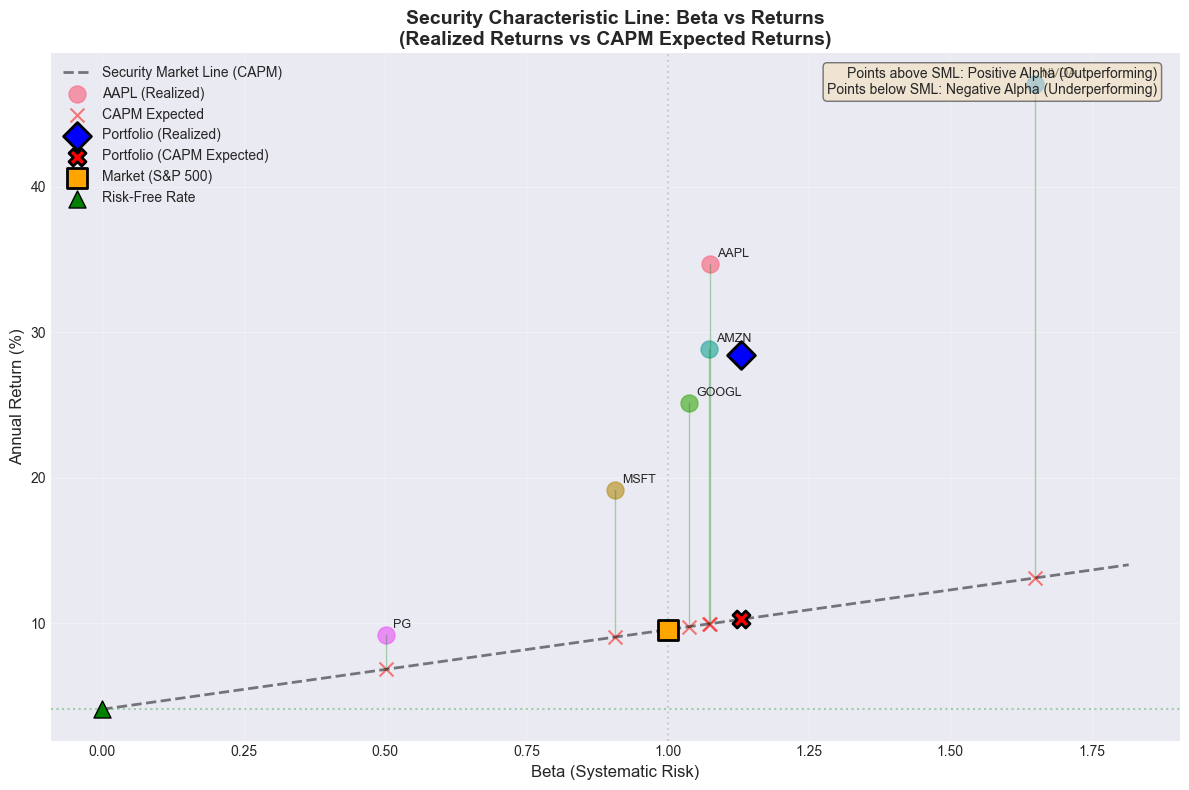


SUMMARY: Beta vs Returns Analysis
Stock          Beta     Realized   CAPM Expected      Alpha
------------------------------------------------------------
AAPL          1.075       34.67%           9.97%     24.70%
MSFT          0.907       19.13%           9.05%     10.08%
GOOGL         1.038       25.13%           9.77%     15.36%
AMZN          1.073       28.83%           9.96%     18.87%
NVDA          1.650       47.02%          13.11%     33.91%
PG            0.502        9.20%           6.84%      2.36%
------------------------------------------------------------
PORTFOLIO     1.130       28.41%          10.27%     18.14%
MARKET        1.000        9.56%           9.56%      0.00%


In [111]:
# Security Characteristic Line - Beta vs Returns Chart
fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# Get the analysis period (using monthly for cleaner visualization)
analysis_period = 'monthly'
market_return = capm_results[analysis_period]['market_return']
rf_rate = current_rf_rate

# Prepare data for individual stocks
stock_betas = []
stock_realized_returns = []
stock_expected_returns = []
stock_names = []

for ticker in PORTFOLIO.keys():
    # Get stock data from the stock_analysis DataFrame
    if ticker in stock_analysis.index:
        beta = stock_analysis.loc[ticker, 'Beta']
        realized_return = stock_analysis.loc[ticker, 'Return (%)'] / 100  # Convert from percentage
        expected_return = rf_rate + beta * (market_return - rf_rate)
        
        stock_betas.append(beta)
        stock_realized_returns.append(realized_return)
        stock_expected_returns.append(expected_return)
        stock_names.append(ticker)

# Add portfolio point
portfolio_beta = capm_results[analysis_period]['beta']
portfolio_realized = capm_results[analysis_period]['portfolio_return']
portfolio_expected = capm_results[analysis_period]['capm_expected_return']

# Create beta range for Security Market Line
beta_range = np.linspace(0, max(stock_betas + [portfolio_beta]) * 1.1, 100)
sml_returns = rf_rate + beta_range * (market_return - rf_rate)

# Plot Security Market Line
ax.plot(beta_range, sml_returns * 100, 'k--', alpha=0.5, linewidth=2, label='Security Market Line (CAPM)')

# Plot individual stocks
for i, ticker in enumerate(stock_names):
    # Realized returns
    ax.scatter(stock_betas[i], stock_realized_returns[i] * 100, s=150, alpha=0.7, 
               marker='o', label=f'{ticker} (Realized)' if i == 0 else '')
    # Expected returns on SML
    ax.scatter(stock_betas[i], stock_expected_returns[i] * 100, s=100, alpha=0.5, 
               marker='x', color='red', label='CAPM Expected' if i == 0 else '')
    
    # Add stock labels
    ax.annotate(ticker, (stock_betas[i], stock_realized_returns[i] * 100), 
                xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    # Draw vertical lines to show alpha (difference between realized and expected)
    ax.plot([stock_betas[i], stock_betas[i]], 
            [stock_expected_returns[i] * 100, stock_realized_returns[i] * 100],
            'g-' if stock_realized_returns[i] > stock_expected_returns[i] else 'r-',
            alpha=0.3, linewidth=1)

# Plot portfolio point
ax.scatter(portfolio_beta, portfolio_realized * 100, s=200, marker='D', 
           color='blue', edgecolor='black', linewidth=2, label='Portfolio (Realized)', zorder=5)
ax.scatter(portfolio_beta, portfolio_expected * 100, s=150, marker='X', 
           color='red', edgecolor='black', linewidth=2, label='Portfolio (CAPM Expected)', zorder=5)

# Plot market point
ax.scatter(1.0, market_return * 100, s=200, marker='s', 
           color='orange', edgecolor='black', linewidth=2, label='Market (S&P 500)', zorder=5)

# Plot risk-free rate
ax.scatter(0, rf_rate * 100, s=150, marker='^', 
           color='green', edgecolor='black', linewidth=1, label='Risk-Free Rate', zorder=5)

# Formatting
ax.set_xlabel('Beta (Systematic Risk)', fontsize=12)
ax.set_ylabel('Annual Return (%)', fontsize=12)
ax.set_title('Security Characteristic Line: Beta vs Returns\n(Realized Returns vs CAPM Expected Returns)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)
ax.legend(loc='upper left', fontsize=10)

# Add horizontal line at risk-free rate
ax.axhline(y=rf_rate * 100, color='green', linestyle=':', alpha=0.3)

# Add vertical line at beta = 1
ax.axvline(x=1.0, color='gray', linestyle=':', alpha=0.3)

# Add text annotations for interpretation - positioned in upper right to avoid legend
textstr = 'Points above SML: Positive Alpha (Outperforming)\nPoints below SML: Negative Alpha (Underperforming)'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', horizontalalignment='right', bbox=props)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSUMMARY: Beta vs Returns Analysis")
print("=" * 60)
print(f"{'Stock':<10} {'Beta':>8} {'Realized':>12} {'CAPM Expected':>15} {'Alpha':>10}")
print("-" * 60)
for i, ticker in enumerate(stock_names):
    alpha = (stock_realized_returns[i] - stock_expected_returns[i]) * 100
    print(f"{ticker:<10} {stock_betas[i]:>8.3f} {stock_realized_returns[i]*100:>11.2f}% "
          f"{stock_expected_returns[i]*100:>14.2f}% {alpha:>9.2f}%")
print("-" * 60)
print(f"{'PORTFOLIO':<10} {portfolio_beta:>8.3f} {portfolio_realized*100:>11.2f}% "
      f"{portfolio_expected*100:>14.2f}% {(portfolio_realized-portfolio_expected)*100:>9.2f}%")
print(f"{'MARKET':<10} {1.000:>8.3f} {market_return*100:>11.2f}% "
      f"{market_return*100:>14.2f}% {0.00:>9.2f}%")

In [112]:
def suggest_portfolio_improvements(stock_analysis, capm_metrics):
    """
    Provide suggestions for portfolio improvement based on CAPM analysis
    """
    print("\n" + "="*80)
    print("PORTFOLIO OPTIMIZATION SUGGESTIONS (Based on Weekly Analysis)")
    print("="*80)
    
    # Identify high and low performers
    stock_analysis_sorted = stock_analysis.sort_values('Alpha (%)', ascending=False)
    
    print("\n1. STOCK PERFORMANCE RANKING (by Alpha):")
    print("-" * 40)
    for idx, (ticker, row) in enumerate(stock_analysis_sorted.iterrows(), 1):
        alpha = row['Alpha (%)']
        beta = row['Beta']
        weight = row['Weight']
        
        if alpha > 2:
            status = "✅ Outperformer"
        elif alpha < -2:
            status = "⚠️  Underperformer"
        else:
            status = "📊 Neutral"
        
        print(f"{idx}. {ticker}: Alpha={alpha:.2f}%, Beta={beta:.2f}, Weight={weight:.1%} - {status}")
    
    # Risk analysis
    high_beta_stocks = stock_analysis[stock_analysis['Beta'] > 1.3]
    low_alpha_stocks = stock_analysis[stock_analysis['Alpha (%)'] < -2]
    
    print("\n2. RISK CONCERNS:")
    print("-" * 40)
    
    if not high_beta_stocks.empty:
        print("High Beta Stocks (>1.3):")
        for ticker in high_beta_stocks.index:
            print(f"  - {ticker}: Beta = {high_beta_stocks.loc[ticker, 'Beta']:.2f}")
        print("  → Consider reducing weights if risk tolerance is low")
    
    if not low_alpha_stocks.empty:
        print("\nUnderperforming Stocks (Alpha < -2%):")
        for ticker in low_alpha_stocks.index:
            print(f"  - {ticker}: Alpha = {low_alpha_stocks.loc[ticker, 'Alpha (%)']:.2f}%")
        print("  → Consider replacing or reducing allocation")
    
    # Portfolio-level suggestions
    portfolio_beta = capm_metrics['beta']
    portfolio_alpha = capm_metrics['alpha_annual']
    
    print("\n3. PORTFOLIO-LEVEL RECOMMENDATIONS:")
    print("-" * 40)
    
    if portfolio_beta > 1.2:
        print("🔴 Portfolio Beta is HIGH ({:.2f})".format(portfolio_beta))
        print("   Suggestions:")
        print("   • Add defensive stocks (utilities, consumer staples)")
        print("   • Increase allocation to lower-beta holdings")
        print("   • Consider adding bonds or other low-correlation assets")
    elif portfolio_beta < 0.8:
        print("🔵 Portfolio Beta is LOW ({:.2f})".format(portfolio_beta))
        print("   Suggestions:")
        print("   • May be too conservative for growth-seeking investors")
        print("   • Consider adding growth stocks if appropriate for risk tolerance")
    else:
        print("✅ Portfolio Beta is MODERATE ({:.2f})".format(portfolio_beta))
    
    if portfolio_alpha < -0.02:
        print("\n⚠️  Portfolio Alpha is NEGATIVE ({:.1f}%)".format(portfolio_alpha * 100))
        print("   Suggestions:")
        print("   • Review stock selection criteria")
        print("   • Consider index fund for market exposure")
        print("   • Rebalance toward top-performing holdings")
    elif portfolio_alpha > 0.02:
        print("\n✅ Portfolio Alpha is POSITIVE ({:.1f}%)".format(portfolio_alpha * 100))
        print("   Current strategy is adding value!")
    
    # Rebalancing suggestions
    print("\n4. REBALANCING SUGGESTIONS:")
    print("-" * 40)
    
    # Calculate optimal weights based on Sharpe ratios
    sharpe_ratios = stock_analysis['Sharpe Ratio']
    if sharpe_ratios.notna().all() and (sharpe_ratios > 0).all():
        # Simple Sharpe-weighted allocation
        optimal_weights = sharpe_ratios / sharpe_ratios.sum()
        
        print("Suggested rebalancing based on risk-adjusted returns:")
        for ticker in PORTFOLIO.keys():
            current_weight = PORTFOLIO[ticker]
            suggested_weight = optimal_weights[ticker]
            change = suggested_weight - current_weight
            
            if abs(change) > 0.05:  # Only show significant changes
                direction = "↑" if change > 0 else "↓"
                print(f"  {ticker}: {current_weight:.1%} → {suggested_weight:.1%} ({direction} {abs(change):.1%})")
    
    print("\n" + "="*80)

# Generate optimization suggestions using WEEKLY analysis
suggest_portfolio_improvements(stock_analysis, capm_results['weekly'])


PORTFOLIO OPTIMIZATION SUGGESTIONS (Based on Weekly Analysis)

1. STOCK PERFORMANCE RANKING (by Alpha):
----------------------------------------
1. NVDA: Alpha=33.24%, Beta=1.65, Weight=15.0% - ✅ Outperformer
2. AAPL: Alpha=24.26%, Beta=1.08, Weight=25.0% - ✅ Outperformer
3. AMZN: Alpha=18.43%, Beta=1.07, Weight=15.0% - ✅ Outperformer
4. GOOGL: Alpha=14.94%, Beta=1.04, Weight=20.0% - ✅ Outperformer
5. MSFT: Alpha=9.71%, Beta=0.91, Weight=10.0% - ✅ Outperformer
6. PG: Alpha=2.16%, Beta=0.50, Weight=15.0% - ✅ Outperformer

2. RISK CONCERNS:
----------------------------------------
High Beta Stocks (>1.3):
  - NVDA: Beta = 1.65
  → Consider reducing weights if risk tolerance is low

3. PORTFOLIO-LEVEL RECOMMENDATIONS:
----------------------------------------
✅ Portfolio Beta is MODERATE (1.05)

✅ Portfolio Alpha is POSITIVE (18.1%)
   Current strategy is adding value!

4. REBALANCING SUGGESTIONS:
----------------------------------------
Suggested rebalancing based on risk-adjusted return

In [113]:
def suggest_portfolio_improvements(stock_analysis, capm_metrics):
    """
    Provide suggestions for portfolio improvement based on CAPM analysis
    """
    print("\n" + "="*80)
    print("PORTFOLIO OPTIMIZATION SUGGESTIONS")
    print("="*80)
    
    # Identify high and low performers
    stock_analysis_sorted = stock_analysis.sort_values('Alpha (%)', ascending=False)
    
    print("\n1. STOCK PERFORMANCE RANKING (by Alpha):")
    print("-" * 40)
    for idx, (ticker, row) in enumerate(stock_analysis_sorted.iterrows(), 1):
        alpha = row['Alpha (%)']
        beta = row['Beta']
        weight = row['Weight']
        
        if alpha > 2:
            status = "✅ Outperformer"
        elif alpha < -2:
            status = "⚠️  Underperformer"
        else:
            status = "📊 Neutral"
        
        print(f"{idx}. {ticker}: Alpha={alpha:.2f}%, Beta={beta:.2f}, Weight={weight:.1%} - {status}")
    
    # Risk analysis
    high_beta_stocks = stock_analysis[stock_analysis['Beta'] > 1.3]
    low_alpha_stocks = stock_analysis[stock_analysis['Alpha (%)'] < -2]
    
    print("\n2. RISK CONCERNS:")
    print("-" * 40)
    
    if not high_beta_stocks.empty:
        print("High Beta Stocks (>1.3):")
        for ticker in high_beta_stocks.index:
            print(f"  - {ticker}: Beta = {high_beta_stocks.loc[ticker, 'Beta']:.2f}")
        print("  → Consider reducing weights if risk tolerance is low")
    
    if not low_alpha_stocks.empty:
        print("\nUnderperforming Stocks (Alpha < -2%):")
        for ticker in low_alpha_stocks.index:
            print(f"  - {ticker}: Alpha = {low_alpha_stocks.loc[ticker, 'Alpha (%)']:.2f}%")
        print("  → Consider replacing or reducing allocation")
    
    # Portfolio-level suggestions
    portfolio_beta = capm_metrics['beta']
    portfolio_alpha = capm_metrics['alpha_annual']
    
    print("\n3. PORTFOLIO-LEVEL RECOMMENDATIONS:")
    print("-" * 40)
    
    if portfolio_beta > 1.2:
        print("🔴 Portfolio Beta is HIGH ({:.2f})".format(portfolio_beta))
        print("   Suggestions:")
        print("   • Add defensive stocks (utilities, consumer staples)")
        print("   • Increase allocation to lower-beta holdings")
        print("   • Consider adding bonds or other low-correlation assets")
    elif portfolio_beta < 0.8:
        print("🔵 Portfolio Beta is LOW ({:.2f})".format(portfolio_beta))
        print("   Suggestions:")
        print("   • May be too conservative for growth-seeking investors")
        print("   • Consider adding growth stocks if appropriate for risk tolerance")
    else:
        print("✅ Portfolio Beta is MODERATE ({:.2f})".format(portfolio_beta))
    
    if portfolio_alpha < -0.02:
        print("\n⚠️  Portfolio Alpha is NEGATIVE ({:.1f}%)".format(portfolio_alpha * 100))
        print("   Suggestions:")
        print("   • Review stock selection criteria")
        print("   • Consider index fund for market exposure")
        print("   • Rebalance toward top-performing holdings")
    elif portfolio_alpha > 0.02:
        print("\n✅ Portfolio Alpha is POSITIVE ({:.1f}%)".format(portfolio_alpha * 100))
        print("   Current strategy is adding value!")
    
    # Rebalancing suggestions
    print("\n4. REBALANCING SUGGESTIONS:")
    print("-" * 40)
    
    # Calculate optimal weights based on Sharpe ratios
    sharpe_ratios = stock_analysis['Sharpe Ratio']
    if sharpe_ratios.notna().all() and (sharpe_ratios > 0).all():
        # Simple Sharpe-weighted allocation
        optimal_weights = sharpe_ratios / sharpe_ratios.sum()
        
        print("Suggested rebalancing based on risk-adjusted returns:")
        for ticker in PORTFOLIO.keys():
            current_weight = PORTFOLIO[ticker]
            suggested_weight = optimal_weights[ticker]
            change = suggested_weight - current_weight
            
            if abs(change) > 0.05:  # Only show significant changes
                direction = "↑" if change > 0 else "↓"
                print(f"  {ticker}: {current_weight:.1%} → {suggested_weight:.1%} ({direction} {abs(change):.1%})")
    
    print("\n" + "="*80)

# Generate optimization suggestions
suggest_portfolio_improvements(stock_analysis, capm_results['monthly'])


PORTFOLIO OPTIMIZATION SUGGESTIONS

1. STOCK PERFORMANCE RANKING (by Alpha):
----------------------------------------
1. NVDA: Alpha=33.24%, Beta=1.65, Weight=15.0% - ✅ Outperformer
2. AAPL: Alpha=24.26%, Beta=1.08, Weight=25.0% - ✅ Outperformer
3. AMZN: Alpha=18.43%, Beta=1.07, Weight=15.0% - ✅ Outperformer
4. GOOGL: Alpha=14.94%, Beta=1.04, Weight=20.0% - ✅ Outperformer
5. MSFT: Alpha=9.71%, Beta=0.91, Weight=10.0% - ✅ Outperformer
6. PG: Alpha=2.16%, Beta=0.50, Weight=15.0% - ✅ Outperformer

2. RISK CONCERNS:
----------------------------------------
High Beta Stocks (>1.3):
  - NVDA: Beta = 1.65
  → Consider reducing weights if risk tolerance is low

3. PORTFOLIO-LEVEL RECOMMENDATIONS:
----------------------------------------
✅ Portfolio Beta is MODERATE (1.13)

✅ Portfolio Alpha is POSITIVE (18.1%)
   Current strategy is adding value!

4. REBALANCING SUGGESTIONS:
----------------------------------------
Suggested rebalancing based on risk-adjusted returns:
  NVDA: 15.0% → 21.7% (↑

In [114]:
# Export results to CSV - WEEKLY ANALYSIS
def export_results():
    # Create results directory
    import os
    if not os.path.exists('capm_results'):
        os.makedirs('capm_results')
    
    # Export CAPM metrics
    results_df.to_csv('capm_results/capm_metrics.csv')
    print("✅ CAPM metrics exported to capm_results/capm_metrics.csv")
    
    # Export individual stock analysis (using weekly data)
    stock_analysis.to_csv('capm_results/stock_analysis_weekly.csv')
    print("✅ Stock analysis (weekly) exported to capm_results/stock_analysis_weekly.csv")
    
    # Export returns data (weekly)
    returns_export = pd.DataFrame({
        'Portfolio_Weekly': portfolio_weekly,
        'Market_Weekly': weekly_returns[MARKET_TICKER]
    })
    returns_export.to_csv('capm_results/weekly_returns_data.csv')
    print("✅ Weekly returns data exported to capm_results/weekly_returns_data.csv")
    
    # Create summary report focusing on WEEKLY analysis
    with open('capm_results/summary_report_weekly.txt', 'w') as f:
        f.write("CAPM PORTFOLIO ANALYSIS SUMMARY (WEEKLY RETURNS)\n")
        f.write("="*50 + "\n\n")
        f.write(f"Analysis Period: {START_DATE} to {END_DATE}\n")
        f.write(f"Portfolio Stocks: {', '.join(PORTFOLIO.keys())}\n")
        f.write(f"Risk-Free Rate: {current_rf_rate:.2%}\n\n")
        
        f.write("KEY FINDINGS (Weekly Analysis):\n")
        f.write("-"*30 + "\n")
        metrics = capm_results['weekly']
        f.write(f"Portfolio Beta: {metrics['beta']:.3f}\n")
        f.write(f"Portfolio Alpha (annual): {metrics['alpha_annual']*100:.2f}%\n")
        f.write(f"Portfolio Return (annual): {metrics['portfolio_return']*100:.2f}%\n")
        f.write(f"CAPM Expected Return: {metrics['capm_expected_return']*100:.2f}%\n")
        f.write(f"Sharpe Ratio: {metrics['portfolio_sharpe']:.3f}\n")
        f.write(f"R-squared: {metrics['r_squared']:.3f}\n")
        f.write(f"Tracking Error: {metrics['tracking_error']*100:.2f}%\n")
        f.write(f"Information Ratio: {metrics['information_ratio']:.3f}\n")
        
        f.write("\n\nComparison Across Time Periods:\n")
        f.write("-"*30 + "\n")
        f.write(f"{'Period':<10} {'Beta':>8} {'Alpha%':>10} {'Return%':>10} {'Sharpe':>10}\n")
        f.write("-"*50 + "\n")
        for period in ['daily', 'weekly', 'monthly']:
            m = capm_results[period]
            f.write(f"{period:<10} {m['beta']:>8.3f} {m['alpha_annual']*100:>10.2f} "
                   f"{m['portfolio_return']*100:>10.2f} {m['portfolio_sharpe']:>10.3f}\n")
    
    print("✅ Summary report (weekly focus) exported to capm_results/summary_report_weekly.txt")
    print("\n📁 All results saved in 'capm_results' directory with weekly analysis focus")

export_results()

✅ CAPM metrics exported to capm_results/capm_metrics.csv
✅ Stock analysis (weekly) exported to capm_results/stock_analysis_weekly.csv
✅ Weekly returns data exported to capm_results/weekly_returns_data.csv
✅ Summary report (weekly focus) exported to capm_results/summary_report_weekly.txt

📁 All results saved in 'capm_results' directory with weekly analysis focus


In [115]:
# Export results to CSV
def export_results():
    # Create results directory
    import os
    if not os.path.exists('capm_results'):
        os.makedirs('capm_results')
    
    # Export CAPM metrics
    results_df.to_csv('capm_results/capm_metrics.csv')
    print("✅ CAPM metrics exported to capm_results/capm_metrics.csv")
    
    # Export individual stock analysis
    stock_analysis.to_csv('capm_results/stock_analysis.csv')
    print("✅ Stock analysis exported to capm_results/stock_analysis.csv")
    
    # Export returns data
    returns_export = pd.DataFrame({
        'Portfolio_Daily': portfolio_daily,
        'Market_Daily': daily_returns[MARKET_TICKER]
    })
    returns_export.to_csv('capm_results/returns_data.csv')
    print("✅ Returns data exported to capm_results/returns_data.csv")
    
    # Create summary report
    with open('capm_results/summary_report.txt', 'w') as f:
        f.write("CAPM PORTFOLIO ANALYSIS SUMMARY\n")
        f.write("="*50 + "\n\n")
        f.write(f"Analysis Period: {START_DATE} to {END_DATE}\n")
        f.write(f"Portfolio Stocks: {', '.join(PORTFOLIO.keys())}\n")
        f.write(f"Risk-Free Rate: {current_rf_rate:.2%}\n\n")
        
        f.write("KEY FINDINGS (Monthly Analysis):\n")
        f.write("-"*30 + "\n")
        metrics = capm_results['monthly']
        f.write(f"Portfolio Beta: {metrics['beta']:.3f}\n")
        f.write(f"Portfolio Alpha (annual): {metrics['alpha_annual']*100:.2f}%\n")
        f.write(f"Portfolio Return (annual): {metrics['portfolio_return']*100:.2f}%\n")
        f.write(f"CAPM Expected Return: {metrics['capm_expected_return']*100:.2f}%\n")
        f.write(f"Sharpe Ratio: {metrics['portfolio_sharpe']:.3f}\n")
        f.write(f"R-squared: {metrics['r_squared']:.3f}\n")
    
    print("✅ Summary report exported to capm_results/summary_report.txt")
    print("\n📁 All results saved in 'capm_results' directory")

export_results()

✅ CAPM metrics exported to capm_results/capm_metrics.csv
✅ Stock analysis exported to capm_results/stock_analysis.csv
✅ Returns data exported to capm_results/returns_data.csv
✅ Summary report exported to capm_results/summary_report.txt

📁 All results saved in 'capm_results' directory
